# RISM - A Gentle Introduction

## Preamble

The code we've written so far:

In [11]:
import numpy as np
from scipy.fftpack import dstn, idstn
import matplotlib.pyplot as plt
from scipy.special import erf

ec = 1.602176565e-19 # A*s
eps_0 = 8.854187817620e-12 # A^2*s^4/kg/m^3
Na = 6.02214129e23 # 1 / mol
kc = 1.0 / 4.0 / np.pi / eps_0 # J*m/A^2/s^2
kc_a = kc * 1e10 # J*angstrom/A^2/s^2
kc_akj = kc_a * 1e-3 # kJ*angstrom/A^2/s^2
kc_akjmol = kc_akj * Na # kJ*angstrom/A^2/s^2/mol
c = ec * ec * kc_akjmol # kJ*angstrom/mol

r = 15.0
N = 100
dr = r / N

dk = 2.0 * np.pi / (2.0 * N * dr)

r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

def Coulomb(q, r):
    return c * q / r

def Ng_real(q, r):
    return c * q * erf(r) / r

def Ng_fourier(q, k):
    return 4.0 * np.pi * c * q * np.exp(-np.power(k, 2.0) / 4.0) / np.power(k, 2.0)

def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

def PY(beta, ur, tr):
    return np.exp(-beta * ur) * (1.0 + tr) - 1.0 - tr

def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r[:, np.newaxis, np.newaxis], type=4, axes=[0]) / k[:, np.newaxis, np.newaxis]

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k[:, np.newaxis, np.newaxis], type=4, axes=[0]) / r[:, np.newaxis, np.newaxis]

def RISM(cr, vk_lr, w, p, r, k, dr, dk):
    N = r.shape[0]
    I = np.eye(w.shape[1])
    tk = np.zeros_like(cr)
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)

    ck -= vk_lr

    # Solve the RISM equation for t(k)
    for l in np.arange(0, N):
        A = np.linalg.inv(I - p @ w[l] @ ck[l])
        B = w[l] @ ck[l] @ w[l]
        tk[l] = A @ B - ck[l]
    
    tk -= vk_lr
    
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

def picard_iteration(closure, tolerance, max_step, alpha, initial_tr, beta, ur_sr, uk_lr,  wk, rho):
    # Set up our loop variable tr
    tr = initial_tr
    
    # Define our counter
    step = 0
    
    while True:
        # Store previous t(r)
        tr_prev = tr

        # t(r) -> c(r) from closure
        cr = closure(beta, ur_sr, tr)

        # c(r) -> F(t(r)) from RISM equation
        f_tr = RISM(cr, beta * uk_lr, wk, rho, r_grid, k_grid, dr, dk)

        # Use Picard iteration to get the new solution
        tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev

         # Check the L^2 norm between iterates
        norm = np.sqrt(np.power((tr_new - tr_prev), 2).sum() * dr)

        # Set t(r) to the new t(r) we just computed
        tr = tr_new

        # Print the iteration step every 100 steps and difference
        if step % 100 == 0:
            print("Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))

        # Test if the difference is below our tolerance
        if norm < tolerance:
            print("Final Iteration: {step} Norm: {norm:.2e}".format(step=step, norm=norm))
            break
        
        # If we reach max_step, raise an error!
        if step == max_step:
            print("Reached max steps!")
            break

        # If any value is nan then the solver has diverged
        if np.any(np.isnan(tr)):
            print("Diverged at iteration: {step}".format(step=step))
            break

        # Update our step counter. We have a max_step because we don't want this calculation to go 
        # on forever and freeze our PC.
        step += 1
    
    # Return solved t(r)
    return tr

## Water - A System of Interest

Water is a particular molecule of interest, and good one to try and model. We are going to use the cSPC/E water model. The principles of this model are essentially the same as nitrogen, except we're working with 3 atoms, rather than 2. We'll use this exercise to write function to programmatically compute the intramolecular function and potential energy as opposed to doing things by hand.

In [12]:
T = 298.15 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

We should set up our inputs so that we can programmatically iterate through them and set up our inputs for arbitrary sizes of systems. To achieve this, we'll just set up lists of parameters and coordinates. We'll then get the potentials from the parameters and intramolecular correlation function from the coordinates.

In [13]:
ns = 3 # Number of sites

ow_eps = 78.15 * kB
ow_sigma = 3.16572
ow_charge = -0.8476

hw_eps = 7.815 * kB
hw_sigma = 1.16572
hw_charge = 0.4238

dens = 0.0334

rho = np.diag([dens] * ns)

params = [ [ow_eps, ow_sigma, ow_charge], [hw_eps, hw_sigma, hw_charge], [hw_eps, hw_sigma, hw_charge] ]

coords = [ np.array([0.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]), np.array([-0.333314, 0.942816, 0.0])]

We'll calculate a distance matrix from the coordinates to be used in the calculation of $\omega(k)$

In [14]:
def dist_matrix(coords, ns):
    ns = len(coords)
    dist = np.zeros((ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist[i, j] = np.linalg.norm(coords[i] - coords[j])
    return dist

And write a function to compute $\omega(k)$ given the coordinates and the Fourier-space grid.

In [15]:
def wk(coords, k, N, ns):
    dists = dist_matrix(coords, ns)
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        dist_ij = dists[i, j]
        if dist_ij == 0.0:
            out[:, i, j] = np.ones(N)
        else:
            out[:, i, j] = np.sin(k * dist_ij) / (k * dist_ij)
    return out

water_wk = wk(coords, k_grid, N, ns)

Now that we're working with different sets of Lennard-Jones parameters, we need to be able to account for cross-interactions too (e.g. the interaction between oxygen and hydrogen in water). We use a mixing rule to do that, in this case the Lorentz-Berthelot mixing rule $$ \sqrt(\epsilon_a \epsilon_b) $$ and $$\frac{\sigma_a + \sigma_b}{2}$$ for some pair of atoms a and b.

In [16]:
def lorentz_berthelot(eps1, eps2, sig1, sig2):
    return np.sqrt(eps1 * eps2), 0.5 * (sig1 + sig2)

We then should write functions that compute the total energy and the screened Coulomb potential for all possible pairs of atoms.

In [17]:
def energy(params, r, N, ns):
    out = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        eps, sig = lorentz_berthelot(
            params[i][0], params[j][0], params[i][1], params[j][1]
        )
        q = params[i][2] * params[j][2]
        out[:, i, j] = LJ(eps, sig, r) + Coulomb(q, r)

    return out

def renorm(params, r, k, N, ns):
    out_r = np.zeros((N, ns, ns))
    out_k = np.zeros((N, ns, ns))
    for i, j in np.ndindex((ns, ns)):
        q = params[i][2] * params[j][2]
        out_r[:, i, j] = Ng_real(q, r)
        out_k[:, i, j] = Ng_fourier(q, k)

    return out_r, out_k

Then getting the energies just takes calling two relatively simple functions for systems of arbitraty size

In [18]:
ur = energy(params, r_grid, N, ns)
ur_lr, uk_lr = renorm(params, r_grid, k_grid, N, ns)

ur_sr = ur - ur_lr

In [19]:
tolerance = 1e-7
max_step = 10000
alpha = 0.7
initial_tr = np.zeros((N, ns, ns))
lambdas = 1

for ilam in range(1, lambdas+1):
    lam = ilam / lambdas
    print(lam)
    tr = picard_iteration(HNC, tolerance, max_step, alpha, initial_tr, beta, lam * ur_sr, lam * uk_lr, water_wk, rho)
    initial_tr = tr


cr = HNC(beta, ur_sr, tr) - beta * ur_lr
tr += beta * ur_lr

1.0
Iteration: 0 Norm: 8.90e+00


Iteration: 100 Norm: 4.25e-01
Iteration: 200 Norm: 1.35e-01
Iteration: 300 Norm: 4.01e-02
Iteration: 400 Norm: 1.10e-02
Iteration: 500 Norm: 2.96e-03
Iteration: 600 Norm: 7.87e-04
Iteration: 700 Norm: 2.09e-04
Iteration: 800 Norm: 5.55e-05
Iteration: 900 Norm: 1.47e-05
Iteration: 1000 Norm: 3.91e-06
Iteration: 1100 Norm: 1.04e-06
Iteration: 1200 Norm: 2.75e-07
Final Iteration: 1277 Norm: 9.91e-08


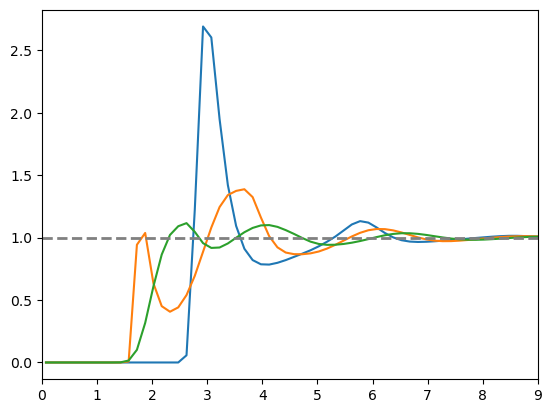

In [20]:
hr = tr + cr

gr = hr + 1.0

plt.plot(r_grid, gr[:, 0, 0])
plt.plot(r_grid, gr[:, 0, 1])
plt.plot(r_grid, gr[:, 1, 1])
plt.axhline(1, color="grey", linestyle="--", linewidth=2)
plt.xlim([0, 9])
plt.show()